# Please execute the following python file first!

```python3 ./libml/extract_accuracies.py```

In [1]:
from glob import glob
import numpy as np
import json
import pandas as pd

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
%matplotlib inline

# Datasets vs accuracy

In [2]:
def summarize_final_results(data='cifar10', split='test', n_last=20):
    '''
    Calculate the mean and standard deviation of results of the last 'n_last' epochs.
    '''

    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['erm','mixup','max_4_','max_6_','max_8_','max_10_']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            try:
                exp_name = '{}_{}_{}'.format(data, model, str(sample))
                path_list = sorted(
                            glob(
                                '../experiments/acc_all/{}10*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)
                            ))
                tmp = []
                for path in path_list:
                    f = json.load(open(path, "r"))
                    tmp.append(pd.DataFrame(f, index=split_list))

                try: 
                    tmp = pd.concat(tmp, sort=False)
                    tmp_test = tmp.loc['test'].iloc[:,-n_last:]
                except:
                    print('Based on the only one seed', model, sample, len(path_list))
                    tmp_test = tmp.loc['test'].iloc[-n_last:]

                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                            'mean': tmp_test.mean().mean(),
                            'std': tmp_test.std().mean()}
                df = df.append(tmp_dict, ignore_index=True)
            except:
                print(model, data, sample)
                pass

    return df

In [3]:
def show_summary_plot(data='cifar10'):
    df_data = summarize_final_results(data=data, n_last=20)
    if data == 'cifar10':
        x_list = [100,500,1000,2500,5000,25000,50000] # np.log([100,500,1000,2500,5000,25000,50000])
    elif data == 'cifar100':
        x_list = [1000,2500,5000,25000,50000] # np.log([1000,2500,5000,25000,50000])
    else:
        assert False, "Please check datasets."
        
    models=['erm','mixup','max_4_','max_6_','max_8_','max_10_']
    names=['ERM','Mixup','max_4_','max_6_','max_8_','max_10_']
    colors=['dodgerblue','green','red','purple','blue','yellow']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('$\log$(# of samples)', fontsize=15)
    plt.ylabel('Test accuracy (in %)', fontsize=15)
    plt.title('Dataset: {}'.format(data), fontsize=15)
    
    for i in range(len(colors)):
        ymean = df_data['mean'][df_data['model']==models[i]]
        yerr = df_data['std'][df_data['model']==models[i]]
        plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.75) 
        plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
    
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    # plt.savefig(outfile, dpi=200, bbox_inches='tight', pad_inches=0)
    plt.show()
    

Based on the only one seed max_4_ 50000 1
Based on the only one seed max_6_ 50000 1
Based on the only one seed max_8_ 50000 1
Based on the only one seed max_10_ 50000 1


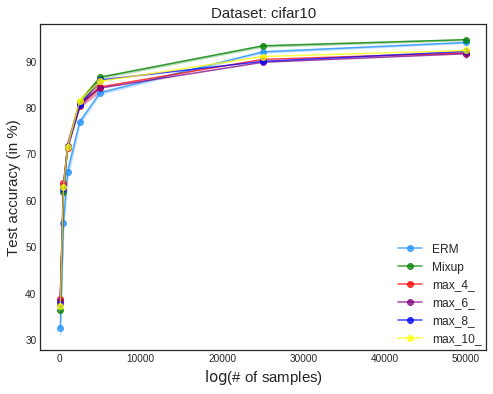

In [4]:
show_summary_plot(data='cifar10')

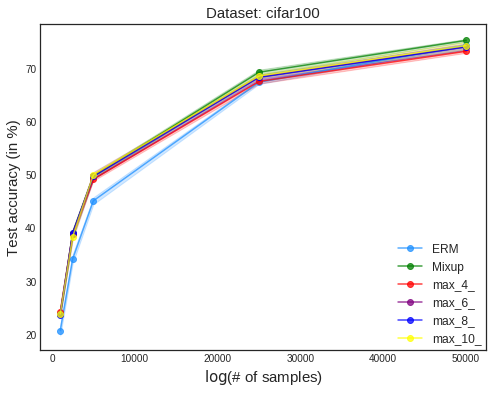

In [5]:
show_summary_plot(data='cifar100')

# Epochs vs generalization gap

In [6]:
def summarize_learning_history(data='cifar10'):
    
    if data == 'cifar10':
        sample_sizes = [100,500,1000,2500,5000,25000,50000]
    elif data == 'cifar100':
        sample_sizes = [1000,2500,5000,25000,50000]
    else:
        assert False, "Please, check datasets"

    models = ['erm','mixup','max_4_','max_10_']
    split_list = ['tr','val','test']
    df = pd.DataFrame(columns=['data','model','sample','mean','std'])

    for model in models:
        for sample in sample_sizes:
            exp_name = '{}_{}_{}'.format(data, model, str(sample))
            path_list = sorted(
                        glob(
                            '../experiments/acc_all/{}10*/{}.*@{}-1/*/accuracies.txt'.format(model, data, sample)
                        ))
            tmp = []
            for path in path_list:
                f = json.load(open(path, "r"))
                tmp.append(pd.DataFrame(f, index=split_list))
            
            tmp = pd.concat(tmp, sort=False)
            generalization_gap = np.array(tmp.loc['tr'])-np.array(tmp.loc['test'])
            
            try:
                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                           'mean': list(np.mean(generalization_gap, axis=0)),
                           'std': list(np.std(generalization_gap, axis=0))}
            except:
                tmp_dict = {'data': data,
                            'model': model,
                            'sample': sample,
                           'mean': list(generalization_gap),
                           'std': np.zeros(len(list(generalization_gap)))}
                
            
            df = df.append(tmp_dict, ignore_index=True)

    return df


In [7]:
def show_generalization_gap(data='cifar10', sample=50000):
    df_cifar10_history = summarize_learning_history(data=data)
    x_list = np.arange(100)
    
    models=['erm','mixup','max_4_','max_10_']
    names=['ERM','Mixup','max_4_','max_10_']
    colors=['dodgerblue','green','red','purple']
    
    plt.figure(figsize=(8,6))
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Generalization gap (in %)', fontsize=15)
    plt.title('Dataset-sample size:{}-{}'.format(data,sample), fontsize=15)
    
    for i in range(len(colors)):
        ind = (df_cifar10_history['model']==models[i]) & (df_cifar10_history['sample']==sample)
        ymean = np.array(df_cifar10_history['mean'][ind].iloc[0])
        yerr = np.array(df_cifar10_history['std'][ind].iloc[0])
        plt.plot(x_list, ymean, marker='o', color=colors[i], label=names[i], alpha=0.5) 
        plt.fill_between(x_list, ymean-yerr, ymean+yerr, alpha=0.2, edgecolor=colors[i], facecolor=colors[i])
        
    plt.legend(loc='lower right', borderaxespad=0., fontsize=12)
    plt.show()

## CIFAR10 dataset

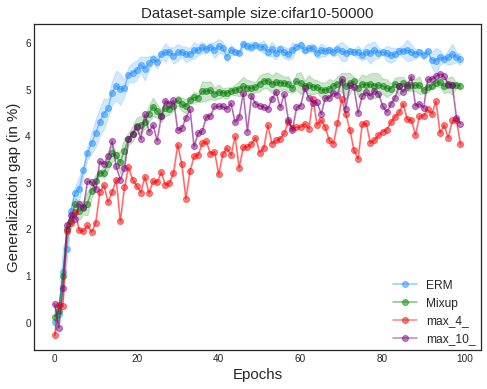

In [8]:
show_generalization_gap(data='cifar10',sample=50000)

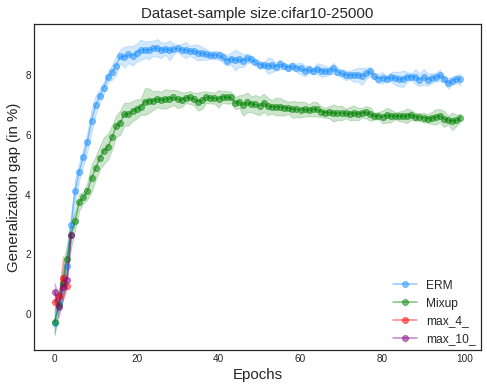

In [9]:
show_generalization_gap(data='cifar10',sample=25000)

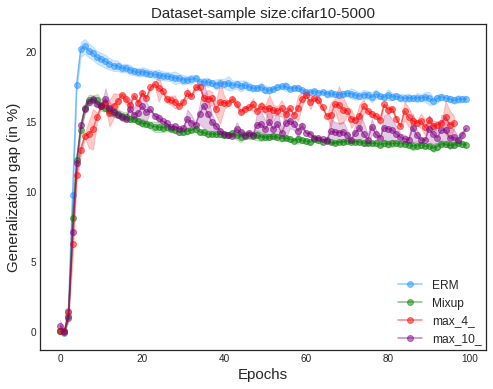

In [10]:
show_generalization_gap(data='cifar10',sample=5000)

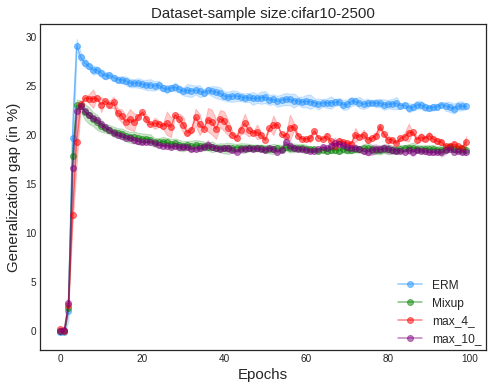

In [11]:
show_generalization_gap(data='cifar10',sample=2500)

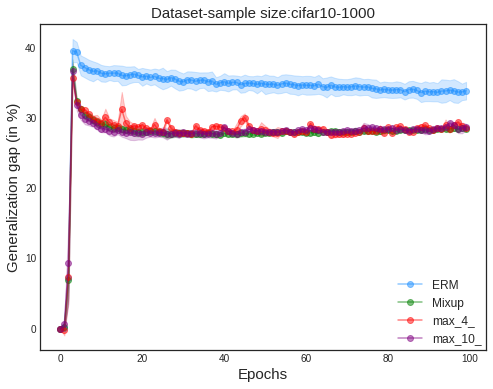

In [12]:
show_generalization_gap(data='cifar10',sample=1000)

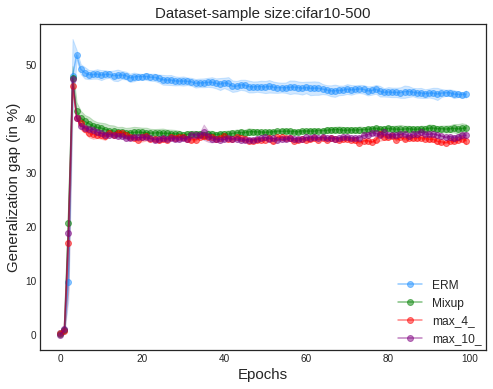

In [13]:
show_generalization_gap(data='cifar10',sample=500)

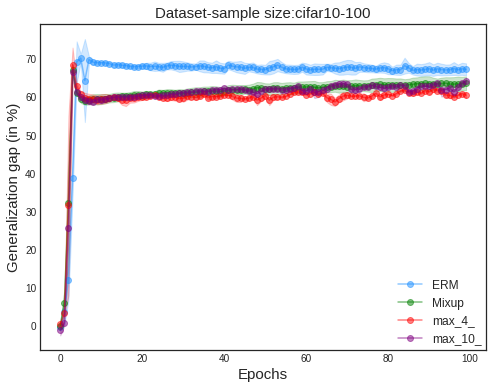

In [14]:
show_generalization_gap(data='cifar10',sample=100)

## CIFAR100 dataset

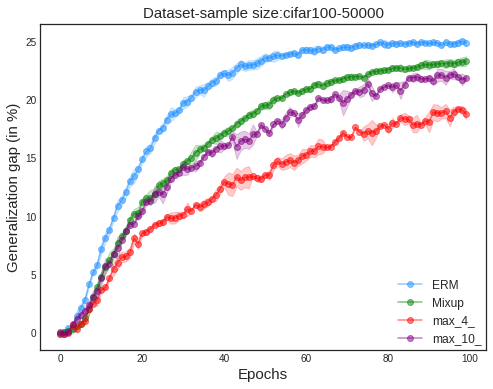

In [15]:
show_generalization_gap(data='cifar100',sample=50000)

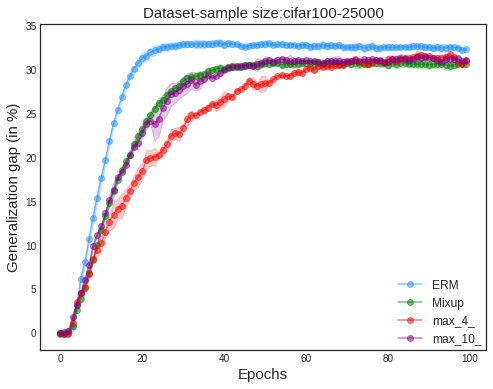

In [16]:
show_generalization_gap(data='cifar100',sample=25000)

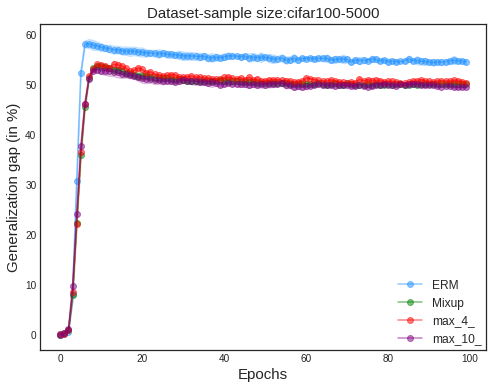

In [17]:
show_generalization_gap(data='cifar100',sample=5000)

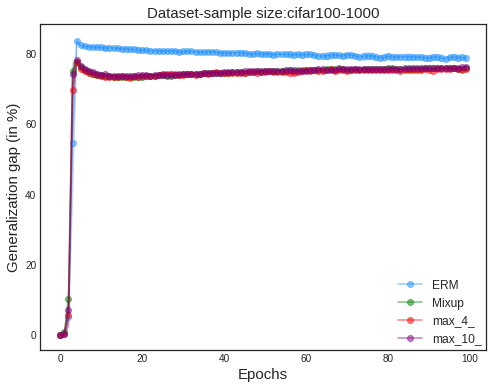

In [18]:
show_generalization_gap(data='cifar100',sample=1000)